# <center> <font size = 24 color = 'steelblue'>**Deep Learning for speech**

<div class="alert alert-block alert-info">
<font size = 4>
    
**By the end of this notebook you will be able to:**
- Apply EDA with audio data    
- Extraction features
- Perform data pre-processing
- Build a CNN model
- Perform Model evaluation

# <a id= 'd0'>
<font size = 4>

**Table of Content**<br>
[1. Data description](#d1)<br>
[2. Exploratory data analysis](#d2)<br>
[3. Data pre-processing](#d3)<br>
[4. Feature extraction](#d4)<br>
[5. Data preparation for model building](#d5)<br>
[6. Model development](#d6)<br>
[7. Post-model analysis](#d7)<br>

##### <a id = 'd1'>
<font size = 10 color = 'midnightblue'> <b>Data Description

<div class="alert alert-block alert-success">
<font size = 4>
    
- The data used here is the `Ryerson Audio-Visual Database of Emotional Speech and Song or RAVDESS`.
- The section of data used here comprises **1440 files**, resulting from **60 trials per actor multiplied by 24 actors**.
- The RAVDESS features 24 professional actors, evenly divided between 12 females and 12 males.
- These actors vocalize two lexically-matched statements in a neutral North American accent.
- Speech emotions included in the dataset encompass calm, happy, sad, angry, fearful, surprise, and disgust expressions.
- Each expression is generated at two levels of emotional intensity, namely normal and strong, with an additional neutral expression.
    
Citation: Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

[top](#d0)

##### <a id = 'd2'>
<font size = 10 color = 'midnightblue'> <b> Exploratory data analysis

<font size = 5 color = seagreen><b> Install and import required libraries

In [1]:
# After installation, restart the session and then run the below cells
! pip install scikeras
! pip3 install resampy

  Using cached scikeras-0.13.0-py3-none-any.whl.metadata (3.1 kB)
Using cached scikeras-0.13.0-py3-none-any.whl (26 kB)


In [2]:
import os
from dotenv import load_dotenv

try:
    from google.colab import drive
    # drive.mount('/content/drive')
    load_dotenv(verbose=True, dotenv_path='.env', override=True)
    DATASET_PATH = os.getenv('COLAB_DATASET_PATH')
    print("Running in Colab environment")
except ModuleNotFoundError:
    load_dotenv(verbose=True, dotenv_path='.env', override=True)
    DATASET_PATH = os.getenv('DATASET_PATH', default='/default/dataset/path')
    print("Running in local environment\n")

Running in local environment



In [3]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV

from scikeras.wrappers import KerasClassifier

import soundfile as sf

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [3]:
# unzip
import os
import zipfile

# READ IN AUDIO FILES
# audio = "/content/ravdess-emotional-speech-audio.zip"
audio = f"{DATASET_PATH}/ravdess-emotional-speech-audio.zip"

# Open the zip file
with zipfile.ZipFile(audio, 'r') as zip_ref:
    # Extract all the contents to a temporary directory
    # zip_ref.extractall('/content/')
    zip_ref.extractall({DATASET_PATH})

<font size = 5 color = pwdrblue><b> Explore wave plots and melspectrograms for various emotions of males and females

<font size = 5 color = seagreen><b> Male Neutral

In [4]:
# address = '/content'
address = DATASET_PATH
# os.listdir('/content/ravdess-emotional-speech-audio/')
os.listdir(f'{DATASET_PATH}/ravdess-emotional-speech-audio/')


['Actor_16',
 'Actor_11',
 'Actor_18',
 'Actor_20',
 'Actor_21',
 'Actor_19',
 'Actor_10',
 'Actor_17',
 '.DS_Store',
 'Actor_04',
 'Actor_03',
 'Actor_02',
 'Actor_05',
 'Actor_12',
 'Actor_15',
 'Actor_23',
 'Actor_24',
 'Actor_22',
 'Actor_14',
 'Actor_13',
 'Actor_09',
 'Actor_07',
 'Actor_06',
 'Actor_01',
 'Actor_08']

In [5]:
# LOAD IN FILE
x, sr = librosa.load(address + '/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav')

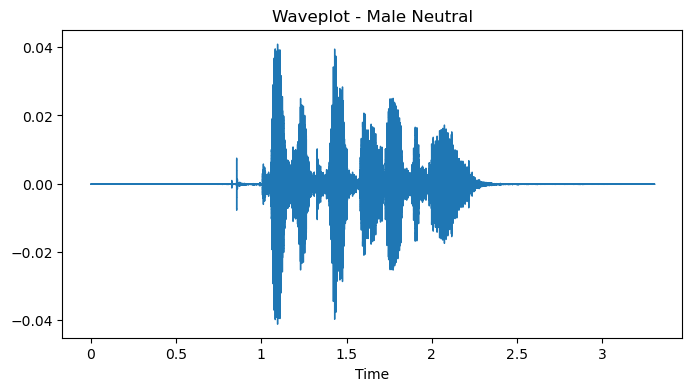

In [6]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Neutral')
plt.savefig(f'{DATASET_PATH}/Waveplot_MaleNeutral.png')

In [7]:
# create a directory for Audio Files
os.mkdir(os.path.join(address , 'IPD_Audio_Files'))

In [8]:
# PLAY AUDIO FILE
sf.write(os.path.join(address , 'IPD_Audio_Files/MaleNeutral.wav'), x, sr)
Audio(data=x, rate=sr)

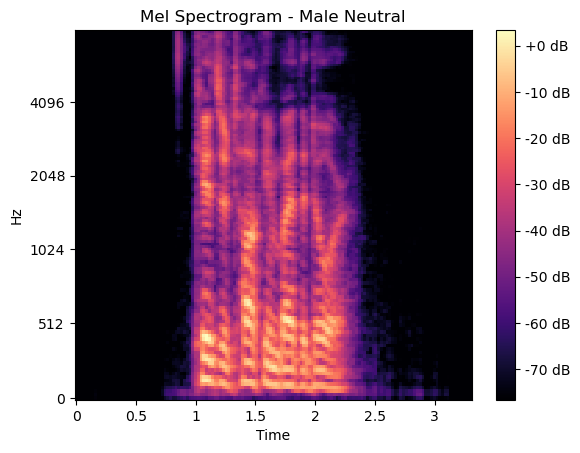

In [9]:
# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Neutral')
plt.savefig(f'{DATASET_PATH}/MelSpec_MaleNeutral.png')
plt.colorbar(format='%+2.0f dB');

<font size = 5 color = seagreen><b> Female Calm

In [10]:
# LOAD IN FILE
x, sr = librosa.load(address + '/ravdess-emotional-speech-audio/Actor_02/03-01-02-01-01-01-02.wav')

In [ ]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Female Calm')
plt.savefig(f'{DATASET_PATH}/Waveplot_FemaleCalm.png')


In [ ]:
# PLAY AUDIO FILE
sf.write(os.path.join(address , 'IPD_Audio_Files/FemaleCalm.wav'), x, sr)
Audio(data=x, rate=sr)

In [ ]:
# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Calm')
plt.savefig(f'{DATASET_PATH}/MelSpec_FemaleCalm.png')
plt.colorbar(format='%+2.0f dB');

<font size = 5 color = seagreen><b> Male Happy

In [14]:
# LOAD FILE
x, sr = librosa.load(address + '/ravdess-emotional-speech-audio/Actor_03/03-01-03-01-01-01-03.wav')

In [ ]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Happy')
plt.savefig(f'{DATASET_PATH}/Waveplot_MaleHappy.png')

In [ ]:
# PLAY AUDIO FILE
sf.write(os.path.join(address , 'IPD_Audio_Files/MaleHappy.wav'), x, sr)
Audio(data=x, rate=sr)

In [ ]:
# CREATE LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
x = librosa.power_to_db(x)

librosa.display.specshow(x, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Happy')
plt.savefig(f'{DATASET_PATH}/MelSpec_MaleHappy.png')
plt.colorbar(format='%+2.0f dB');

<font size = 5 color = seagreen><b> Female Sad

In [18]:
# LOAD FILE
x, sr = librosa.load(address + '/ravdess-emotional-speech-audio/Actor_04/03-01-04-01-01-01-04.wav')


In [ ]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Female Sad')
plt.savefig(f'{DATASET_PATH}/Waveplot_FemaleSad.png')

In [ ]:
# PLAY AUDIO FILE
sf.write(os.path.join(address , 'IPD_Audio_Files/FemaleSad.wav'), x, sr)
Audio(data=x, rate=sr)

In [ ]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Sad');
plt.savefig(f'{DATASET_PATH}/MelSpec_FemaleSad.png')
plt.colorbar(format='%+2.0f dB');

<font size = 5 color = seagreen><b> Male Angry

In [22]:
# LOAD FILE
x, sr = librosa.load(address + '/ravdess-emotional-speech-audio/Actor_05/03-01-05-01-01-01-05.wav')


In [ ]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Angry')
plt.savefig(f'{DATASET_PATH}/Waveplot_MaleAngry.png')

In [ ]:
# PLAY AUDIO FILE
sf.write(os.path.join(address , 'IPD_Audio_Files/MaleAngry.wav'), x, sr)
Audio(data=x, rate=sr)

In [ ]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Angry');
plt.savefig(f'{DATASET_PATH}/MelSpec_MaleAngry.png')
plt.colorbar(format='%+2.0f dB');

<font size = 5 color = seagreen><b> Female Fearful

In [26]:
# LOAD FILE
x, sr = librosa.load(address + '/ravdess-emotional-speech-audio/Actor_06/03-01-06-01-01-01-06.wav')

In [ ]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Female Fearful')
plt.savefig(f'{DATASET_PATH}/Waveplot_FemaleFearful.png')


In [ ]:
# PLAY AUDIO FILE
sf.write(os.path.join(address , 'IPD_Audio_Files/FemaleFearful.wav'), x, sr)
Audio(data=x, rate=sr)

In [ ]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Fearful')
plt.savefig(f'{DATASET_PATH}/MelSpec_FemaleFearful.png')
plt.colorbar(format='%+2.0f dB');

<font size = 5 color = seagreen><b> Male Disgust

In [30]:
# LOAD FILE
x, sr = librosa.load(address + '/ravdess-emotional-speech-audio/Actor_07/03-01-07-01-01-01-07.wav')

In [ ]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Disgust')
plt.savefig(f'{DATASET_PATH}/Waveplot_MaleDisgust.png')

In [ ]:
# PLAY AUDIO FILE
sf.write(os.path.join(address , 'IPD_Audio_Files/MaleDisgust.wav'), x, sr)
Audio(data=x, rate=sr)

In [ ]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Disgust')
plt.savefig(f'{DATASET_PATH}/MelSpec_MaleDisgust.png')
plt.colorbar(format='%+2.0f dB');

<font size = 5 color = seagreen><b> Female Surprised

In [34]:
# LOAD FILE
x, sr = librosa.load(address + '/ravdess-emotional-speech-audio/Actor_08/03-01-08-01-01-01-08.wav')

In [ ]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - FemaleSurprised')
plt.savefig(f'{DATASET_PATH}/Waveplot_FemaleSurprised.png')


In [ ]:
# PLAY AUDIO FILE
sf.write(os.path.join(address , 'IPD_Audio_Files/FemaleSurprised.wav'), x, sr)
Audio(data=x, rate=sr)

In [ ]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Surprised')
plt.savefig(f'{DATASET_PATH}/MelSpec_FemaleSurprised.png')
plt.colorbar(format='%+2.0f dB');

[top](#d0)

##### <a id = 'd3'>
<font size = 10 color = 'midnightblue'> <b>  Data Preprocessing

<font size = 5 color = pwdrblue><b> Labeling Audio Files

In [ ]:
# CREATE DIRECTORY OF AUDIO FILES
audio = address + "/ravdess-emotional-speech-audio/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort()
actor_folders[0:5]

In [ ]:
actor_folders = [act for act in actor_folders if act not in('.DS_Store', 'ipynb_checkpoints')]
len(actor_folders)

<font size = 5 color = pwdrblue><b> Create function to extract emotion number, actor and gender label

In [40]:
emotion = []
gender = []
actor = []
file_path = []

for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

<font size = 5 color = pwdrblue><b> Put extracted labels with filepath into dataframe

In [ ]:
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df

<font size = 5 color = pwdrblue><b>  Ensure gender,emotion, and actor column values are correct

<font size = 5 color = pwdrblue><b> Look at distribution of classes

In [ ]:
audio_df.emotion.value_counts().plot(kind='bar')

<font size = 5 color = pwdrblue><b> Export to csv file

In [43]:
audio_df.to_csv(address + '/audio.csv')

[top](#d0)

##### <a id = 'd4'>
<font size = 10 color = 'midnightblue'> <b>  Feature extraction

<font size = 5 color = pwdrblue><b> Iterate over all audio files and extract log mel spectrogram mean values into df for modeling

In [ ]:
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)

    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)

    df.loc[counter] = [log_spectrogram]
    counter=counter+1

print(len(df))
df.head()

In [46]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)

In [47]:
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)

In [ ]:
# CHECK TOP 5 ROWS
df_combined.head()

[top](#d0)

##### <a id = 'd5'>
<font size = 10 color = 'midnightblue'> <b>   Prepping Data for Modeling

In [49]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['emotion','gender','actor']])

In [ ]:
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

In [ ]:
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)

<font size = 5 color = pwdrblue><b>  Data standardization

In [52]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [53]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

In [ ]:
print(lb.classes_)

In [ ]:
# RESHAPE DATA TO INCLUDE 3D TENSOR
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

X_train.shape

##### <a id = 'd6'>
<font size = 10 color = 'midnightblue'> <b>  Model development

<font size = 5 color = pwdrblue><b>   Base Model

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
y_train.shape, y_test.shape

In [ ]:
import numpy as np
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)


<font size = 5 color = pwdrblue><b>  Initial Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

In [ ]:
import tensorflow.keras as keras

# FIT MODEL AND USE CHECKPOINT TO SAVE BEST MODEL
checkpoint = ModelCheckpoint("best_initial_model.weights.h5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', save_freq=1, save_weights_only=True)

model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test),callbacks=[checkpoint])

In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'{DATASET_PATH}/Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(f'{DATASET_PATH}/Initial_Model_loss.png')
plt.show()

[top](#do)

##### <a id = 'd7'>
<font size = 10 color = 'midnightblue'> <b>   Post-Model Analysis

In [ ]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

In [ ]:
# PREDICTIONS
predictions = model.predict(X_test)
predictions=predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH
finaldf = actual.join(predictions)
finaldf[140:150]

In [ ]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig(f'{DATASET_PATH}/Initial_Model_Confusion_Matrix.png')
plt.show()

In [ ]:
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))